# 구글 드라이브 허용

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd "/content/drive/My Drive/dacon_jeju"; ls -l

total 1049339
-rw------- 1 root root   8847328 Oct 20 11:30 4.1350782688_submit_cbr.csv
-rw------- 1 root root   8842466 Oct 19 14:34 5.0306451151_submit_xgb_lgb_cbr.csv
-rw------- 1 root root       778 Oct 17 13:59 data_info.csv
-rw------- 1 root root   4077384 Oct 17 13:59 sample_submission.csv
-rw------- 1 root root   8463916 Oct 27 14:22 submit_dsc.csv
-rw------- 1 root root   8843638 Oct 21 13:13 submit_ensemble_cbr_lgb.csv
-rw------- 1 root root   8847609 Oct 23 08:24 submit_ensemble_cbr_tuning.csv
-rw------- 1 root root   8846719 Oct 27 14:53 submit_ensemble_dsc_rfr.csv
-rw------- 1 root root   8846049 Oct 23 13:48 submit_ensemble_rfr_cbr1.csv
-rw------- 1 root root   8847609 Oct 23 08:24 submit_ensemble_rfr.csv
-rw------- 1 root root   8846561 Nov  6 14:23 submit_feature_importance_rfr.csv
-rw------- 1 root root   8819092 Oct 17 14:59 submit_test2.csv
-rw------- 1 root root   8844102 Oct 17 14:51 submit_test.csv
-rw------- 1 root root   8841356 Oct 19 14:18 submit_test_ensemble

# Auto EDA Sweetviz

In [ ]:
pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 5.2 MB/s 


# Catboost installation

In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 35.7 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


# 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor ## import libraries
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
# import sweetviz
# %matplotlib inline
import xgboost

# Use MAE!
from sklearn.metrics import mean_absolute_error

# cross validation module
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold

# 데이터 불러오기

In [ ]:
train = pd.read_csv('/content/drive/My Drive/dacon_jeju/train.csv')
test = pd.read_csv('/content/drive/My Drive/dacon_jeju/test.csv')
df_info = pd.read_csv('/content/drive/My Drive/dacon_jeju/data_info.csv')

In [ ]:
df_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


## Auto EDA

In [ ]:
auto_report = sweetviz.compare([train, 'train'], [test, 'test'], 'target')

NameError: ignored

In [ ]:
auto_report.show_html("/content/drive/My Drive/dacon_jeju/train.html")

-> 따로 파일 구글드라이브에서 확인후 다운로드 받아서 브라우저로열것

# EDA

In [ ]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [ ]:
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,0.0,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.0,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.0,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.0,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,0.0,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음


In [ ]:
train.isnull().any()

id                       False
base_date                False
day_of_week              False
base_hour                False
lane_count               False
road_rating              False
road_name                False
multi_linked             False
connect_code             False
maximum_speed_limit      False
vehicle_restricted       False
weight_restricted        False
height_restricted        False
road_type                False
start_node_name          False
start_latitude           False
start_longitude          False
start_turn_restricted    False
end_node_name            False
end_latitude             False
end_longitude            False
end_turn_restricted      False
target                   False
dtype: bool

In [ ]:
test.isnull().any()

id                       False
base_date                False
day_of_week              False
base_hour                False
lane_count               False
road_rating              False
road_name                False
multi_linked             False
connect_code             False
maximum_speed_limit      False
vehicle_restricted       False
weight_restricted        False
height_restricted        False
road_type                False
start_node_name          False
start_latitude           False
start_longitude          False
start_turn_restricted    False
end_node_name            False
end_latitude             False
end_longitude            False
end_turn_restricted      False
dtype: bool

null값은 없는것으로 확인함.

In [ ]:
train.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4701217.0,4.701217e+06,4701217.0,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,2.021672e+07,1.192820e+01,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.125329e+01,0.0,5.618742e+03,0.0,6.152237e-01,3.338432e+01,1.265217e+02,3.338432e+01,1.265217e+02,4.278844e+01
std,4.555709e+03,6.722092e+00,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.213354e+01,0.0,1.395343e+04,0.0,1.211268e+00,1.012015e-01,1.563657e-01,1.011948e-01,1.563519e-01,1.595443e+01
min,2.021090e+07,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.324343e+01,1.261826e+02,3.324343e+01,1.261826e+02,1.000000e+00
25%,2.021110e+07,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.326422e+01,1.264232e+02,3.326422e+01,1.264232e+02,3.000000e+01
50%,2.022013e+07,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.341257e+01,1.265112e+02,3.341257e+01,1.265112e+02,4.300000e+01
75%,2.022050e+07,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.347804e+01,1.265840e+02,3.347804e+01,1.265840e+02,5.400000e+01
max,2.022073e+07,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,0.0,5.000000e+04,0.0,3.000000e+00,3.355608e+01,1.269309e+02,3.355608e+01,1.269309e+02,1.130000e+02


In [ ]:
test.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude
count,2.912410e+05,291241.000000,291241.000000,291241.000000,291241.0,291241.0,291241.000000,291241.0,291241.000000,291241.0,291241.000000,291241.000000,291241.000000,291241.000000,291241.000000
mean,2.022082e+07,11.856854,2.021371,105.245948,0.0,0.0,58.771430,0.0,3651.902033,0.0,0.634845,33.361624,126.512946,33.361651,126.512919
std,8.886111e+00,6.803378,0.750898,1.862653,0.0,0.0,11.390743,0.0,11327.618389,0.0,1.225362,0.116064,0.061478,0.116067,0.061344
min,2.022080e+07,0.000000,1.000000,103.000000,0.0,0.0,30.000000,0.0,0.000000,0.0,0.000000,33.243432,126.303780,33.243432,126.303780
25%,2.022081e+07,6.000000,1.000000,103.000000,0.0,0.0,50.000000,0.0,0.000000,0.0,0.000000,33.254214,126.476508,33.254214,126.476508
50%,2.022082e+07,12.000000,2.000000,106.000000,0.0,0.0,60.000000,0.0,0.000000,0.0,0.000000,33.272222,126.512046,33.272222,126.512046
75%,2.022082e+07,18.000000,3.000000,107.000000,0.0,0.0,70.000000,0.0,0.000000,0.0,0.000000,33.492718,126.561830,33.492718,126.561830
max,2.022083e+07,23.000000,3.000000,107.000000,0.0,0.0,80.000000,0.0,50000.000000,0.0,3.000000,33.521399,126.912948,33.521399,126.912948


In [ ]:
test['vehicle_restricted'].unique()

array([0.])

column 중 vehicle_restricted, height_restricted는 train과 test데이터 모두 0밖에 없는것으로 확인 되었다.


### Categorical variable이 있는 column 조사

In [ ]:
train.dtypes

id                        object
base_date                  int64
day_of_week               object
base_hour                  int64
lane_count                 int64
road_rating                int64
road_name                 object
multi_linked               int64
connect_code               int64
maximum_speed_limit      float64
vehicle_restricted       float64
weight_restricted        float64
height_restricted        float64
road_type                  int64
start_node_name           object
start_latitude           float64
start_longitude          float64
start_turn_restricted     object
end_node_name             object
end_latitude             float64
end_longitude            float64
end_turn_restricted       object
target                   float64
dtype: object

In [ ]:
test.dtypes

id                        object
base_date                  int64
day_of_week               object
base_hour                  int64
lane_count                 int64
road_rating                int64
road_name                 object
multi_linked               int64
connect_code               int64
maximum_speed_limit      float64
vehicle_restricted       float64
weight_restricted        float64
height_restricted        float64
road_type                  int64
start_node_name           object
start_latitude           float64
start_longitude          float64
start_turn_restricted     object
end_node_name             object
end_latitude             float64
end_longitude            float64
end_turn_restricted       object
dtype: object

In [ ]:
train['end_node_name'].value_counts()

고성교차로              42265
산신주유소              29202
구엄교                27510
미수2교               26621
영주교                24370
                   ...  
외산리사무소               881
대흘교차로                788
서귀포시 서호동 308-6       744
서귀포시 호근동 1838-4      744
CU서귀호근로점             587
Name: end_node_name, Length: 487, dtype: int64

## 평균값등의 대푯값들 확인

In [ ]:
train.describe()

,base_date,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4701217.0,4.701217e+06,4701217.0,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,2.021672e+07,1.192820e+01,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.125329e+01,0.0,5.618742e+03,0.0,6.152237e-01,3.338432e+01,1.265217e+02,3.338432e+01,1.265217e+02,4.278844e+01
std,4.555709e+03,6.722092e+00,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.213354e+01,0.0,1.395343e+04,0.0,1.211268e+00,1.012015e-01,1.563657e-01,1.011948e-01,1.563519e-01,1.595443e+01
min,2.021090e+07,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.324343e+01,1.261826e+02,3.324343e+01,1.261826e+02,1.000000e+00
25%,2.021110e+07,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.326422e+01,1.264232e+02,3.326422e+01,1.264232e+02,3.000000e+01
50%,2.022013e+07,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.341257e+01,1.265112e+02,3.341257e+01,1.265112e+02,4.300000e+01
75%,2.022050e+07,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.0,0.000000e+00,0.0,0.000000e+00,3.347804e+01,1.265840e+02,3.347804e+01,1.265840e+02,5.400000e+01
max,2.022073e+07,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,0.0,5.000000e+04,0.0,3.000000e+00,3.355608e+01,1.269309e+02,3.355608e+01,1.269309e+02,1.130000e+02


# Data preprocessing

In [ ]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [ ]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted', "height_restricted"], axis=1)

test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted', "height_restricted"], axis=1)

# drop하는 맨뒤의 2개 feature들은 faeture importance에서 중요도가 낮았던 feature들임 -> feature importance값 반영했지만 public score엔 오히려 성능저하

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 15)
(4701217,)
(291241, 15)


## correlation확인

In [ ]:
cor_train = pd.concat([X_train,train['target']], axis =1)

In [ ]:
cor_train

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,target
0,1,17,1,106,0,0,60.0,32400.0,3,33.427747,126.662612,0,33.427749,126.662335,0,52.0
1,1,21,2,103,0,0,60.0,0.0,0,33.500730,126.529107,1,33.504811,126.526240,0,30.0
2,4,7,2,103,0,0,80.0,0.0,0,33.279145,126.368598,0,33.280072,126.362147,0,61.0
3,0,13,2,107,0,0,50.0,0.0,0,33.246081,126.567204,0,33.245565,126.566228,0,20.0
4,6,8,2,103,0,0,80.0,0.0,0,33.462214,126.326551,0,33.462677,126.330152,0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,1,16,1,107,0,0,50.0,0.0,0,33.422145,126.278125,0,33.420955,126.273750,0,20.0
4701213,1,2,2,107,0,0,80.0,43200.0,3,33.472505,126.424368,0,33.472525,126.424890,0,65.0
4701214,3,22,2,103,0,0,60.0,0.0,0,33.447183,126.912579,0,33.444121,126.912948,0,30.0
4701215,2,2,2,103,0,0,80.0,0.0,0,33.443596,126.431817,0,33.444996,126.433332,0,73.0


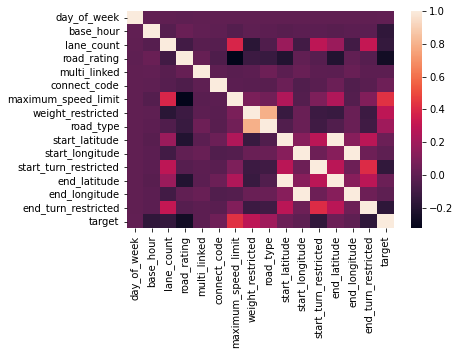

In [ ]:
# # Set the width and height of the figure
# plt.figure(figsize=(14,7))

# # Add title
# plt.title("Mean speed correlation")

# # Heatmap showing average arrival delay for each airline by month
# sns.heatmap(data=X_train, annot=True)

sns.heatmap(cor_train.corr())

correlation분석에 따르면 <br/>
road_type - weight_restricted<br/>
start_latitude - end_latitude<br/>
start_longitude - end_longitude<br/>
끼리 다소 높은 상관관계를 나타내는 것으로 확인된다.<br/>
그나마 target value와 correlation이 높은 feature은 maximum speed limit과 weight restricted로 확인 되었다.

In [ ]:
X_train.describe()

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
count,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06,4.701217e+06
mean,2.984018e+00,1.192820e+01,1.836651e+00,1.049585e+02,4.762597e-04,2.660218e-01,6.125329e+01,5.618742e+03,6.152237e-01,3.338432e+01,1.265217e+02,9.816947e-02,3.338432e+01,1.265217e+02,9.819117e-02
std,2.001977e+00,6.722092e+00,6.877513e-01,1.840107e+00,2.181818e-02,5.227760e+00,1.213354e+01,1.395343e+04,1.211268e+00,1.012015e-01,1.563657e-01,2.975437e-01,1.011948e-01,1.563519e-01,2.975730e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,3.324343e+01,1.261826e+02,0.000000e+00,3.324343e+01,1.261826e+02,0.000000e+00
25%,1.000000e+00,6.000000e+00,1.000000e+00,1.030000e+02,0.000000e+00,0.000000e+00,5.000000e+01,0.000000e+00,0.000000e+00,3.326422e+01,1.264232e+02,0.000000e+00,3.326422e+01,1.264232e+02,0.000000e+00
50%,3.000000e+00,1.200000e+01,2.000000e+00,1.060000e+02,0.000000e+00,0.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00,3.341257e+01,1.265112e+02,0.000000e+00,3.341257e+01,1.265112e+02,0.000000e+00
75%,5.000000e+00,1.800000e+01,2.000000e+00,1.070000e+02,0.000000e+00,0.000000e+00,7.000000e+01,0.000000e+00,0.000000e+00,3.347804e+01,1.265840e+02,0.000000e+00,3.347804e+01,1.265840e+02,0.000000e+00
max,6.000000e+00,2.300000e+01,3.000000e+00,1.070000e+02,1.000000e+00,1.030000e+02,8.000000e+01,5.000000e+04,3.000000e+00,3.355608e+01,1.269309e+02,1.000000e+00,3.355608e+01,1.269309e+02,1.000000e+00


# Blending을 위한 train validation split

In [ ]:
from sklearn.model_selection import train_test_split
X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
# concat을 위해서 index initializing
X_train_B = X_train_B.reset_index(drop=True)

In [ ]:
X_val_B = X_val_B.reset_index(drop=True)

In [ ]:
y_train_B = y_train_B.reset_index(drop=True)

In [ ]:
y_val_B = y_val_B.reset_index(drop=True)

## Blending을 하려면 맨 아래 line으로 가기

# straitified k-fold Cross Validation

In [ ]:
#Validation function

def cross_val(model, X_train, y_train):
  skf =  StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
  score = np.negative(cross_val_score(model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=skf))
  return(score)
# n_folds = 5

# def mae_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
#     mae= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(mae)

# 모델 선언

# Decision tree

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth = 5)
clf = clf.fit(X_train, y_train)

## CV score of decision tree

In [ ]:
score = cross_val(clf, X_train, y_train)
clf_score = score.mean()
print("DecisionTreeRegression score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

'''
no parameter tuning cv:3.5524 / public: 3.8795654817

'''

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


KeyboardInterrupt: ignored

## Random Forest

### 최적의 hyperparameter 추출

https://www.kaggle.com/code/arjunprasadsarkhel/simple-random-forest-with-hyperparameter-tuning

In [ ]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [ ]:
model_rfr = RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = model_rfr,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

### feature importance추출

노답 columns들을 제거하여 모델의 안정성을 늘려보자!

In [ ]:
model_rfr = model_rfr.fit(X_train, y_train)

In [ ]:
model_rfr.feature_importances_
importances = [7.29724476e-03, 8.18600461e-02, 8.95891038e-03, 9.99688335e-02,
       2.43017000e-05, 2.13059718e-04, 2.61820600e-01, 1.17200393e-03,
       5.50880277e-03, 7.36590634e-02, 7.87498702e-02, 2.85792013e-03,
       1.41851198e-01, 2.34721807e-01, 1.33633867e-03]

feature = X_train.columns
importances = pd.DataFrame(importances, columns = ['importances'])
importances['feature'] = feature
importances

,importances,feature
0,0.007297,day_of_week
1,0.081860,base_hour
2,0.008959,lane_count
3,0.099969,road_rating
4,0.000024,multi_linked
5,0.000213,connect_code
6,0.261821,maximum_speed_limit
7,0.001172,weight_restricted
8,0.005509,road_type
9,0.073659,start_latitude


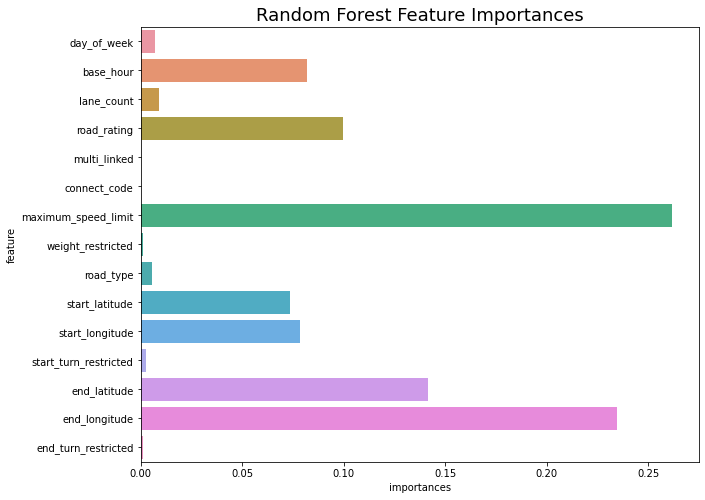

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importances', y='feature', data=importances)
plt.title('Random Forest Feature Importances', fontsize=18)
plt.show()

# Permutation importance

permutation importance를 구하기 위한 validation set나누기

In [ ]:
from sklearn.model_selection import train_test_split
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
model_rfr = RandomForestRegressor(random_state=42)
model_rfr = model_rfr.fit(X_train_t, y_train_t)

permutation importace 사용을 위한 eli5 설치

In [ ]:
pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt

perm_imp = PermutationImportance(model_rfr, scoring='neg_mean_absolute_error', random_state=200)
perm_imp.fit(X_val, y_val)

PermutationImportance(estimator=RandomForestRegressor(random_state=42),
                      random_state=200, scoring='neg_mean_absolute_error')

In [ ]:
perm_imp_df = pd.DataFrame()
feature = X_train.columns
perm_imp_df["feature"] = feature
perm_imp_df["importance"] = perm_imp.feature_importances_
perm_imp_df.sort_values(by='importance', ascending=False, inplace=True)
perm_imp_df.reset_index(drop=True, inplace=True)
perm_imp_df

,feature,importance
0,end_longitude,6.629428
1,end_latitude,5.064855
2,maximum_speed_limit,4.355443
3,road_rating,3.629291
4,start_longitude,3.034087
5,base_hour,2.453518
6,start_latitude,2.320813
7,lane_count,0.460019
8,road_type,0.293502
9,day_of_week,0.164363


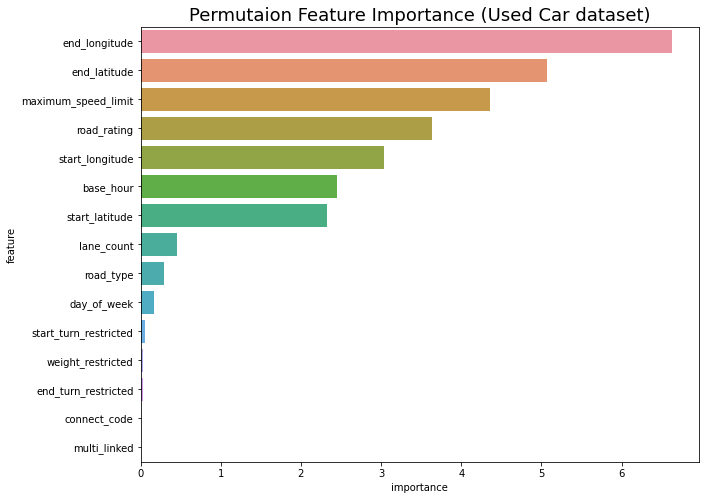

In [ ]:
# 순열 중요도 시각화
plt.figure(figsize=(10, 8))

sns.barplot(x='importance', y='feature', data=perm_imp_df)
plt.title('Permutaion Feature Importance (Used Car dataset)', fontsize=18)

plt.show()

In [ ]:
# 특성 중요도와 각 특성들의 표준편차 확인
eli5.show_weights(perm_imp, feature_names = list(feature))

Weight,Feature
6.6294 ± 0.0177,end_longitude
5.0649 ± 0.0080,end_latitude
4.3554 ± 0.0068,maximum_speed_limit
3.6293 ± 0.0063,road_rating
3.0341 ± 0.0024,start_longitude
2.4535 ± 0.0060,base_hour
2.3208 ± 0.0044,start_latitude
0.4600 ± 0.0041,lane_count
0.2935 ± 0.0013,road_type
0.1644 ± 0.0022,day_of_week


In [ ]:
# 안정성이 있는 특성들
X_train.columns[perm_imp.feature_importances_ - perm_imp.feature_importances_std_ > 0]

Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_latitude', 'start_longitude', 'start_turn_restricted',
       'end_latitude', 'end_longitude', 'end_turn_restricted'],
      dtype='object')

https://velog.io/@rsj9987/TIL-21.06.24-feature-importance<br/>
permutation importance 참고자료

## CV score

In [ ]:
score = cross_val(model_rfr, X_train, y_train)
rfr_score = score.mean()
print("RandomForestRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

'''
random_state=1 / cv score:  3.5520 (0.0019) sota! / public score: 3.8792117401
n_estimators = 1000, max_depth = 32, min_samples_split = 5, random_state=42 / cv score: / public score:

'''

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


KeyboardInterrupt: ignored

무작위숲 옵튜나 참고
https://www.kaggle.com/code/sifodhara/houseprice-prediction-using-randomforest-regressor

## LGBM

In [ ]:
model_lgb = lgb.LGBMRegressor()


In [ ]:
score = cross_val(model_lgb, X_train, y_train)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

5.0076709467

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


LGBMRegressor score: 4.8082 (0.0223)


## Xgboost

In [ ]:
model_xgb = xgboost.XGBRegressor()

In [ ]:
score = cross_val(model_xgb, X_train, y_train)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

# cv
# XGBRegressor score: 6.5654 (0.0345) -> 아무것도 하이퍼 파라미터 튜닝 안한것
# public score -> 6.7369544137

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


[14:16:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor score: 6.5654 (0.0345)


## Catboost regressor

In [ ]:
model_CBR = CatBoostRegressor(
                              verbose = False)

In [ ]:
score = cross_val(model_CBR, X_train, y_train)
CBR_score = score.mean()
print("CatboostRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

# hyper parameter(learning_rate = 0.01, depth = 10) : 5.0042 (0.0049)(cv_score) /5.1638722775(public)
# (random_state = 42,  n_estimators = 1000, learning_rate = 0.01, depth = 10, verbose = False) :  4.9971 (0.0066)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


CatboostRegressor score: 4.9971 (0.0066)


# Model fit & Prediction

In [ ]:
model_rfr = model_rfr.fit(X_train, y_train)

In [ ]:
model_lgb = model_lgb.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
model_xgb = model_xgb.fit(X_train, y_train)

NameError: ignored

In [ ]:
model_CBR = model_CBR.fit(X_train, y_train)

# Blending 시작(Blendingd용 line)

Decision Tree meta data 생성

In [ ]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(random_state=42)
clf = clf.fit(X_train_B, y_train_B)

In [ ]:
# val, test predict하기
meta_val_dcs = pd.DataFrame(clf.predict(X_val_B), columns = ['meta_val_dcs'])
meta_test_dcs = pd.DataFrame(clf.predict(test), columns = ['meta_val_dcs'])

In [ ]:
meta_val_dcs

,meta_val_dcs
0,48.296296
1,56.260870
2,31.360000
3,56.681818
4,52.760000
...,...
1551397,40.933333
1551398,24.400000
1551399,72.000000
1551400,65.550000


Rfr meta data 생성

In [ ]:
model_rfr = RandomForestRegressor(random_state=42)
model_rfr = model_rfr.fit(X_train_B, y_train_B)

In [ ]:
# val, test predict하기
meta_val_rfr = pd.DataFrame(model_rfr.predict(X_val_B), columns = ['meta_val_rfr'])
meta_test_rfr = pd.DataFrame(model_rfr.predict(test),columns = ['meta_val_rfr'])

In [ ]:
meta_test_rfr

,meta_val_rfr
0,24.901136
1,44.555992
2,65.596862
3,37.958131
4,45.411549
...,...
291236,48.248938
291237,51.874171
291238,22.416002
291239,24.270304


meta data concat

In [ ]:
df_val=pd.concat([X_val_B, meta_val_dcs, meta_val_rfr],axis=1)
df_test=pd.concat([test, meta_test_dcs, meta_test_rfr],axis=1)

In [ ]:
df_test

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,meta_val_dcs,meta_val_rfr
0,1,17,3,107,0,0,70.0,0.0,0,33.499427,126.541298,0,33.500772,126.543837,1,24.925926,24.901136
1,6,12,2,103,0,0,70.0,0.0,3,33.258507,126.427003,0,33.258119,126.415840,0,44.647059,44.555992
2,0,2,1,103,0,0,60.0,0.0,0,33.258960,126.476508,0,33.259206,126.474687,0,65.653846,65.596862
3,1,23,3,103,0,0,70.0,0.0,0,33.473494,126.545647,0,33.471061,126.545467,0,38.200000,37.958131
4,2,17,3,106,0,0,70.0,0.0,0,33.501477,126.569223,0,33.496863,126.581230,0,45.413793,45.411549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,5,5,1,103,0,0,80.0,0.0,0,33.472819,126.463030,0,33.470483,126.460846,0,48.346154,48.248938
291237,0,20,2,103,0,0,60.0,0.0,0,33.305359,126.598914,0,33.300796,126.600332,0,51.666667,51.874171
291238,0,11,1,107,0,0,30.0,0.0,0,33.493624,126.496769,1,33.497500,126.496946,1,22.333333,22.416002
291239,0,7,2,107,0,0,60.0,0.0,0,33.254782,126.507014,0,33.255659,126.507333,0,24.500000,24.270304


# meta model xgboost

In [ ]:
# 시간이 없으니 무작위숲이랑 결정나무 부터
meta_model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

xgb train with validation meta data

In [ ]:
meta_model_xgb = meta_model_xgb.fit(df_val, y_val_B)  # y데이터는 원래의 validation으로 fit/ xdata는 meta data 적용

In [ ]:
# test set columns 이름 맞출것!

Predict는 처음 모델들의 meta test prediction data로 predict하기 

In [ ]:
meta_test_xgb = meta_model_xgb.predict(df_test)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/dacon_jeju/sample_submission.csv')

In [ ]:
sample_submission['target'] = meta_test_xgb
sample_submission.to_csv("/content/drive/MyDrive/dacon_jeju/submit_blending.csv", index = False)

In [ ]:
sample_submission

,id,target
0,TEST_000000,24.761667
1,TEST_000001,44.406616
2,TEST_000002,64.983017
3,TEST_000003,38.126350
4,TEST_000004,45.060341
...,...,...
291236,TEST_291236,47.848011
291237,TEST_291237,51.770042
291238,TEST_291238,22.658958
291239,TEST_291239,24.973974


# Prediction

In [ ]:
pred_dcs = clf.predict(test)

In [ ]:
pred_rfr = model_rfr.predict(test)

In [ ]:
pred_lgb = model_lgb.predict(test)

In [ ]:
pred_xgb = model_xgb.predict(test)

In [ ]:
pred_cbr = model_CBR.predict(test)

In [ ]:
pred_ensemble = (pred_rfr + pred_dcs) / 2

# Ensemble MAE

# Submission

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/dacon_jeju/sample_submission.csv')

In [ ]:
sample_submission['target'] = pred_rfr
sample_submission.to_csv("/content/drive/MyDrive/dacon_jeju/submit_feature_importance_rfr.csv", index = False)

In [ ]:
sample_submission

,id,target
0,TEST_000000,24.498811
1,TEST_000001,44.398055
2,TEST_000002,65.224078
3,TEST_000003,37.912710
4,TEST_000004,45.335344
...,...,...
291236,TEST_291236,48.189742
291237,TEST_291237,51.363196
291238,TEST_291238,22.467919
291239,TEST_291239,24.272578


parquet변환 다시 해보기

https://greatjoy.tistory.com/m/72

# Submission record

**Submission Rank**
1. rfr만 돌렸을때 -> 3.8792117401	(최고점수)
2. rfr + cbr -> 3.9242160
3. cbr만 돌렸을때 -> 4.1350782688 
4. lgb + cbr -> 4.4799808734
5. lgbm만 돌렸을때 -> 	5.0076709467	
6. lgb + xgb + cbr -> 	5.0306451151
7. xgb + lgb -> 5.7296031267

- xgb -> 6.7369544137	
- lgb hyperparameter tuning -> 8.3865124332

https://2-chae.github.io/category/1.ai/28

# colab 자동 클릭 매크로

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}setInterval(ClickConnect, 1800000)

https://brother-big.tistory.com/11

ensemble 성능 : validaition도 앙상블하고 평가

다음에 해볼것 -><br/> 
rfr 하이퍼 파라미터 튜닝 옵튜나
<br>
categorical variable encoding, label encoding만 했던거 데이터 특성 본다음에 다른걸로 바꾸기/ 버린 칼럼들 새로 추가하고 의미 없는 칼럼들 없애버리기<br>
https://techblog-history-younghunjo1.tistory.com/99